# DPCM Card Game Simulator

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

sns.set()

### Analysis

In [2]:
df = pd.read_csv('../data/results.csv')
df.head()

,Winner,Turns,Rate
0,Human,20,0.000000
1,AI,26,0.500000
2,Human,31,0.333333
3,Human,14,0.250000
4,AI,20,0.400000


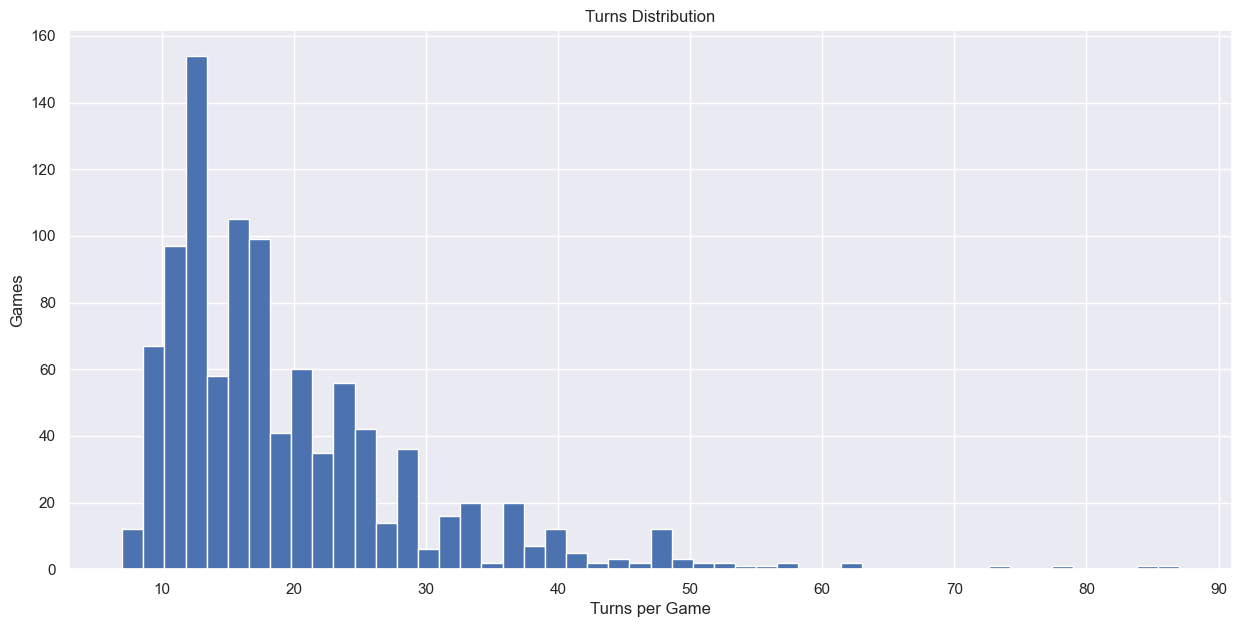

In [4]:
fig = plt.figure(1, figsize=(15, 7))

plt.hist(df["Turns"], bins=50, edgecolor = "w")
plt.title("Turns Distribution")
plt.xlabel("Turns per Game")
plt.ylabel("Games")

plt.show()

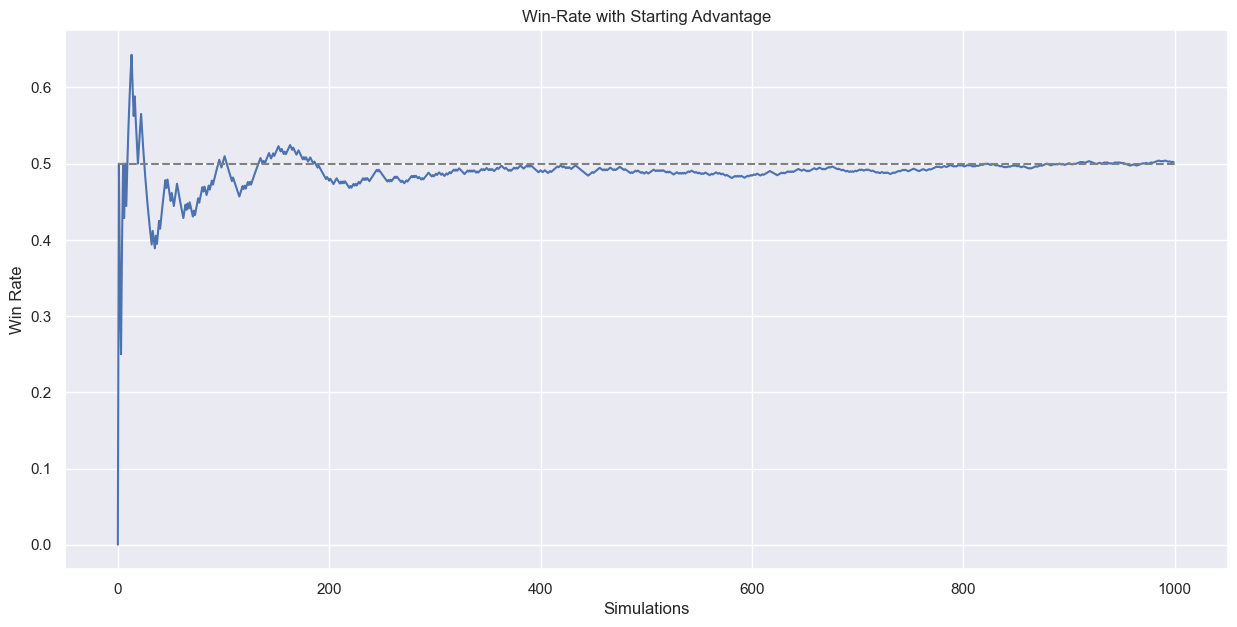

In [5]:
fig = plt.figure(1, figsize=(15, 7))

plt.plot(df.index, df["Rate"])
plt.hlines(0.5, 0, len(df), colors="grey", linestyles="dashed")

plt.title("Win-Rate with Starting Advantage")
plt.xlabel("Simulations")
plt.ylabel("Win Rate")
plt.show()

#### Q-Values

In [58]:
q_values = pd.read_csv('../data/q.csv')

In [59]:
q_values

,ID,ZONE_WHITE,ZONE_YELLOW,ZONE_ORANGE,ZONE_RED,ZONE_BLACK,CERTIFICATION_YELLOW,CERTIFICATION_ORANGE,CERTIFICATION_RED,WILD_VACCINE,WILD_+1,WILD_+2,WILD_+3,WILD_SKIP
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786427,"(5, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
786428,"(5, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
786429,"(5, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
786430,"(5, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
actions = q_values.columns

In [60]:
q_values['MAX'] = q_values.iloc[:, 1:].max(axis=1)

In [56]:
q_values['ID'] = q_values.index

In [62]:
q_values['HAND'] = q_values['ID'].apply(lambda x: sum(eval(x)[1:]))

q_values.head(3)

,ID,ZONE_WHITE,ZONE_YELLOW,ZONE_ORANGE,ZONE_RED,ZONE_BLACK,CERTIFICATION_YELLOW,CERTIFICATION_ORANGE,CERTIFICATION_RED,WILD_VACCINE,WILD_+1,WILD_+2,WILD_+3,WILD_SKIP,MAX,HAND
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [68]:
q_curve = q_values.copy()
q_curve[["HAND","MAX"]] = q_curve[["HAND","MAX"]].replace(0, np.NaN)

q_mean = pd.Series(q_curve.iloc[:, 1:].groupby("HAND").mean()["MAX"])
q_max  = pd.Series(q_curve.iloc[:, 1:].groupby("HAND").max()["MAX"])
q_std  = pd.Series(q_curve.iloc[:, 1:].groupby("HAND").std()["MAX"])/2

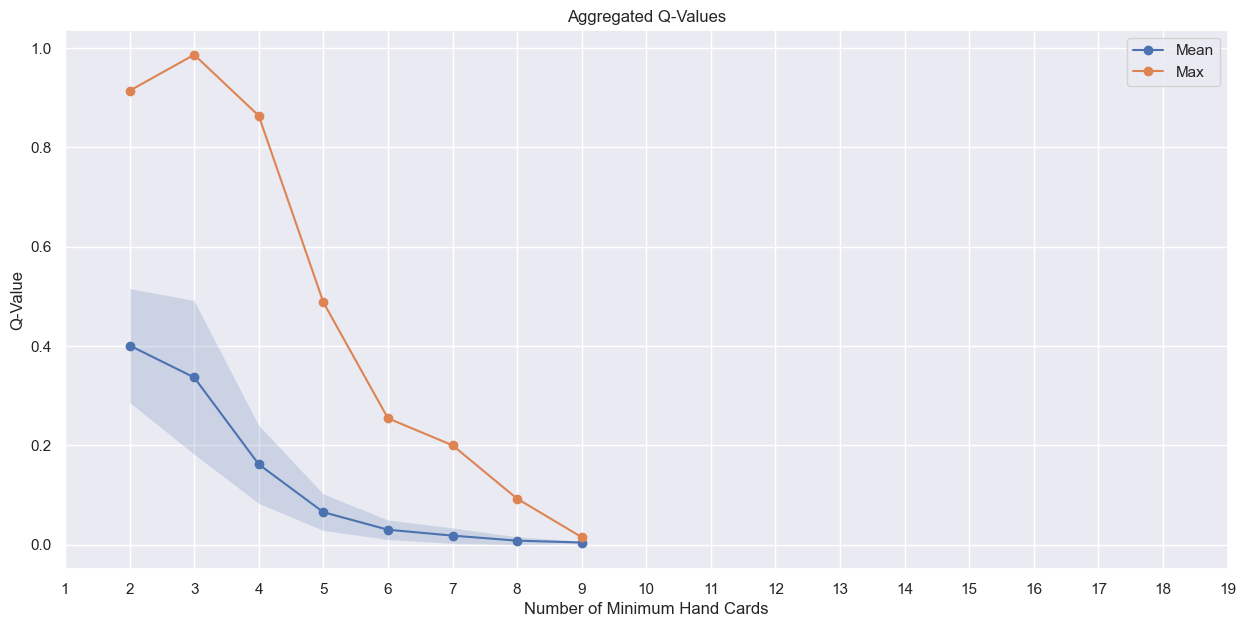

In [70]:
fig = plt.figure(1, figsize=(15,7))

plt.plot(q_mean.index, q_mean, label="Mean", marker = "o")
plt.plot(q_max.index,  q_max,  label="Max",  marker = "o")
plt.fill_between(q_mean.index, q_mean-q_std, q_mean+q_std, alpha=0.2)

plt.xticks(q_mean.index)
plt.xlabel("Number of Minimum Hand Cards")
plt.ylabel("Q-Value")
plt.title("Aggregated Q-Values")
plt.legend()
plt.show()

c:\Users\andre\miniconda3\envs\dpcm-card-game\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


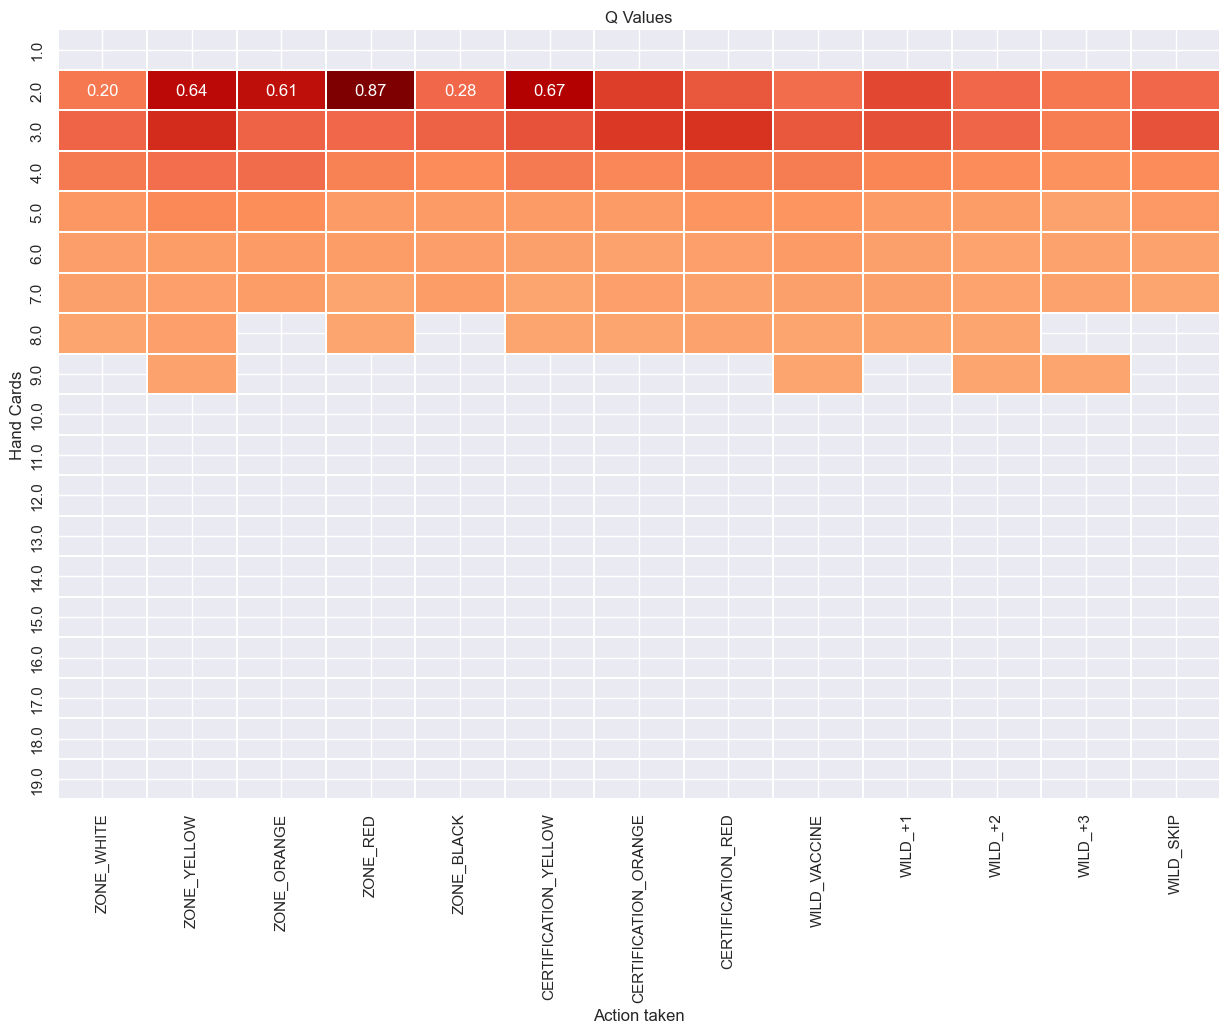

In [73]:
q_pivot = q_values.replace(0, np.NaN)
q_pivot = q_pivot.drop(columns='MAX').iloc[:, 1:].groupby("HAND").mean()

# Plotting
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(q_pivot, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Q Values")
ax.set(xlabel="Action taken", ylabel="Hand Cards")
plt.show()